Credit risk analytics

In [231]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

In [232]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score

In [233]:
loan = pd.read_csv('C:/Alabs/Datasets/bankloans - 1656936041780.csv', sep= ',')
loan

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0
...,...,...,...,...,...,...,...,...,...
845,34,1,12,15,32,2.7,0.239328,0.624672,NaN
846,32,2,12,11,116,5.7,4.026708,2.585292,NaN
847,48,1,13,11,38,10.8,0.722304,3.381696,NaN
848,35,2,1,11,24,7.8,0.417456,1.454544,NaN


In [234]:
def fn_desc( x ):
    # missing values calculation
    ntot = x.shape[0]
    n = x.count()
    n_miss = ntot - n
    n_miss_perc = n_miss/ntot
    
    # get the lc and uc using IQR
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    IQR = q3 - q1
    lc_iqr = q1 - 1.5 * IQR
    uc_iqr = q3 + 1.5 * IQR
    
    # return the descriptives
    
    return pd.Series([x.dtype, x.nunique(),
                       ntot, n, n_miss, n_miss_perc,
                      IQR, lc_iqr, uc_iqr,
                      x.sum(), x.mean(), x.var(), x.std(),
                      x.min(), 
                      x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                      x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                      x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), 
                      x.max() ],
                     index = ['dtype', 'cardinality',
                               'ntot', 'n', 'n_miss', 'n_miss_perc',
                              'IQR', 'lc_iqr', 'uc_iqr',
                              'sum', 'mean', 'var', 'std',
                              'min', 
                              'p1', 'p5', 'p10', 
                              'p25', 'p50', 'p75', 
                              'p90', 'p95', 'p99',
                              'max' ])

In [236]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [237]:
loan.default.value_counts()

default
0.0    517
1.0    183
Name: count, dtype: int64

In [238]:
loan.default.notna().sum()

700

In [239]:
loan.default.value_counts() / loan.default.notna().sum()

default
0.0    0.738571
1.0    0.261429
Name: count, dtype: float64

Since 150 records do not have a label, dividing the dataset into 2 parts 'exist_loan' and 'new_loan'

In [240]:
exist_loan = loan[loan.default.notna()]
exist_loan.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [241]:
new_loan = loan[loan.default.isna()]
new_loan.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN


In [242]:
exist_loan.shape

(700, 9)

In [243]:
new_loan.shape

(150, 9)

In [244]:
exist_loan.apply( fn_desc)


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtype,int64,int64,int64,int64,int64,float64,float64,float64,float64
cardinality,37,5,32,31,114,231,695,699,2
ntot,700,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700,700
n_miss,0,0,0,0,0,0,0,0,0
n_miss_perc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IQR,11.0,1.0,9.0,9.0,31.0,9.125,1.532896,2.878887,1.0
lc_iqr,12.5,-0.5,-10.5,-10.5,-22.5,-8.6875,-1.930284,-3.274152,-1.5
uc_iqr,56.5,3.5,25.5,25.5,101.5,27.8125,4.201299,8.241395,2.5
sum,24402,1206,5872,5795,31921,7182.4,1087.486972,2140.746028,183.0


In [247]:
exist_loan.columns.difference(['ed'])

Index(['address', 'age', 'creddebt', 'debtinc', 'default', 'employ', 'income',
       'othdebt'],
      dtype='object')

In [ ]:
# separating categorical and continuous variables
cat = exist_loan['ed']
cont = exist_loan[exist_loan.columns.difference(['ed'])]

In [221]:
def impute_outlier_iqr(df):
    cols = df.columns
    q1 = df[cols].quantile(0.25)
    q3 = df[cols].quantile(0.75)
    iqr = q3 - q1
    lc = q1 - (1.5 * iqr)
    uc = q3 + (1.5 * iqr)

    df = np.clip(df, lc, uc, axis = 1 )
    return df
    

In [249]:
exist_loan = impute_outlier_iqr(cont)

In [250]:
cont.apply(fn_desc)

,address,age,creddebt,debtinc,default,employ,income,othdebt
dtype,int64,int64,float64,float64,float64,int64,int64,float64
cardinality,31,37,695,231,2,32,114,699
ntot,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700
n_miss,0,0,0,0,0,0,0,0
n_miss_perc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IQR,9.0,11.0,1.532896,9.125,1.0,9.0,31.0,2.878887
lc_iqr,-10.5,12.5,-1.930284,-8.6875,-1.5,-10.5,-22.5,-3.274152
uc_iqr,25.5,56.5,4.201299,27.8125,2.5,25.5,101.5,8.241395
sum,5795,24402,1087.486972,7182.4,183.0,5872,31921,2140.746028


In [255]:
exist_loan_OT = pd.concat([cont, cat], axis = 1 )
exist_loan_OT

,address,age,creddebt,debtinc,default,employ,income,othdebt,ed
0,12,41,11.359392,9.3,1.0,17,176,5.008608,3
1,6,27,1.362202,17.3,0.0,10,31,4.000798,1
2,14,40,0.856075,5.5,0.0,15,55,2.168925,1
3,14,41,2.658720,2.9,0.0,15,120,0.821280,1
4,0,24,1.787436,17.3,1.0,2,28,3.056564,2
...,...,...,...,...,...,...,...,...,...
695,15,36,0.262062,4.6,1.0,6,27,0.979938,2
696,4,29,0.369495,11.5,0.0,6,21,2.045505,2
697,3,33,0.491264,7.6,0.0,15,32,1.940736,1
698,22,45,2.302608,8.4,0.0,19,77,4.165392,1


In [264]:
corr_df = exist_loan_OT.corr()
corr_df

,address,age,creddebt,debtinc,default,employ,income,othdebt,ed
address,1.000000,0.597591,0.208435,0.011323,-0.164451,0.322334,0.316245,0.226514,0.056919
age,0.597591,1.000000,0.295207,0.016398,-0.137657,0.536497,0.478710,0.340217,0.022325
creddebt,0.208435,0.295207,1.000000,0.501767,0.244740,0.403694,0.570199,0.633104,0.088274
debtinc,0.011323,0.016398,0.501767,1.000000,0.389575,-0.031182,-0.026777,0.584870,0.008838
default,-0.164451,-0.137657,0.244740,0.389575,1.000000,-0.282978,-0.070970,0.145713,0.114676
employ,0.322334,0.536497,0.403694,-0.031182,-0.282978,1.000000,0.619681,0.406091,-0.153621
income,0.316245,0.478710,0.570199,-0.026777,-0.070970,0.619681,1.000000,0.610659,0.235190
othdebt,0.226514,0.340217,0.633104,0.584870,0.145713,0.406091,0.610659,1.000000,0.165459
ed,0.056919,0.022325,0.088274,0.008838,0.114676,-0.153621,0.235190,0.165459,1.000000


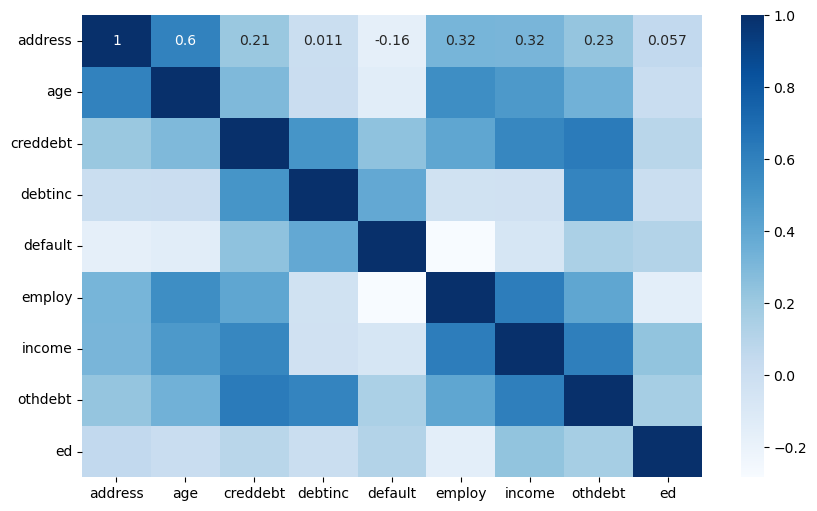

In [267]:

plt.figure(figsize = (10, 6))
sns.heatmap(corr_df, cmap = "Blues", annot = True) 
plt.show()